In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split , learning_curve  ,GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor  
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Importing and Analysing Data

In [2]:
train_data_ = pd.read_excel('Data.xlsx',sheet_name = 'Train_Data').rename(columns = {50:'50s',100:'100s'})
test_data_  =pd.read_excel('Data.xlsx',sheet_name = 'Test_Data').rename(columns = {50:'50s',100:'100s'})
print(train_data_.head())
train_data_[train_data_['Avg']=='-'] = 30
test_data_[test_data_['Avg']=='-'] = 30

# print(train_data.describe())

            PLAYER  Mat  Inns  NO  2018_Runs   HS    Avg   BF      SR  100s  \
0      Aaron Finch   10     9   1        134   46  16.75  100  134.00     0   
1   AB de Villiers   12    11   2        480  90*  53.33  275  174.54     0   
2  Abhishek Sharma    3     3   2         63  46*     63   33  190.90     0   
3   Ajinkya Rahane   15    14   1        370  65*  28.46  313  118.21     0   
4       Alex Hales    6     6   0        148   45  24.66  118  125.42     0   

   50s  4s  6s  2019_Runs  
0    0   6   8        160  
1    6  39  30        424  
2    0   3   5         63  
3    1  39   5        396  
4    0  13   6        165  


In [3]:
print(train_data_.columns)
print(test_data_.columns)

Index(['PLAYER', 'Mat', 'Inns', 'NO', '2018_Runs', 'HS', 'Avg', 'BF', 'SR',
       '100s', '50s', '4s', '6s', '2019_Runs'],
      dtype='object')
Index(['PLAYER', 'Mat', 'Inns', 'NO', '2019_Runs', 'HS', 'Avg', 'BF', 'SR',
       '100s', '50s', '4s', '6s'],
      dtype='object')


Training avg : mean = 25.272499999999994 , median = 23.145
Testing avg : mean = 25.22109999999999 , median = 23.705


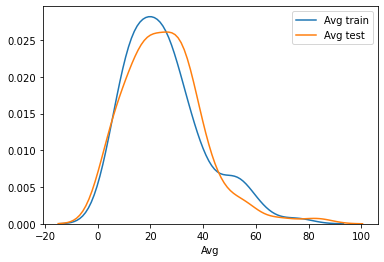

In [4]:
sns.distplot(train_data_['Avg'],label = 'Avg train',hist = False)
sns.distplot(test_data_['Avg'],label = 'Avg test',hist = False)
print("Training avg : mean = {0} , median = {1}".format(np.mean(train_data_['Avg']),np.median(train_data_['Avg'])))
print("Testing avg : mean = {0} , median = {1}".format(np.mean(test_data_['Avg']),np.median(test_data_['Avg'])))

# Feature Engineering

In [5]:
#Function to clear asterisk from high score
def clear_ast(x):
    if type(x) == str:
        if x[-1] == '*':
            return int(x[:-1])
    return int(x)
    
def data_cleaning(data):
    ''' 1 Since Innings and Matches are closely related its better to take their ratio and applying log for breaking the dependency
        2 Then * from High Scores were filtered.
        3 Player names and Not Outs can be dropped due to lesser significance and to reduce complexity.
        4 Runs scored only by boundaries also forms an important measure thus dropping 4s and 6s individually.
        5 Balls Faced and Runs in last tournament are incorporated in Strike Rate  so we drop BF but shall keep the runs as they highly 
          signify the runs in next year.
        6 Also the run rate scored by running between the wickets is an important parameter and shall be made and kept
          by dividing other than boundary runs by balls faced for the same .'''
    data['Inns'] /= data['Mat']
    data['Inns'].apply(np.log)
    data['HS'] = data['HS'].apply(clear_ast)
    data = data.drop(['PLAYER','NO'],axis = 1)
    data['Boundary_scores'] = data['4s']*4 + data['6s'] *6
    data['Boundary_hits'] = data['4s'] + data['6s']
    
    
    #To clean data separately for train and test datasets:
    
    if '2018_Runs' in data.columns:
        data['Singles_and_doubles_rate'] = (data['2018_Runs'] -data['Boundary_scores'])/ (data['BF']-(data['4s'] + data['6s']))
        data = data.drop(['4s','6s'],axis = 1)
        data = data[['Mat', 'Inns', '2018_Runs','Avg', 'SR', '100s', '50s',
       'Boundary_scores','Boundary_hits','Singles_and_doubles_rate','2019_Runs']]
    else:
        data['Singles_and_doubles_rate'] = (data['2019_Runs'] -data['Boundary_scores'])/ (data['BF']-(data['4s'] + data['6s']))
        data = data.drop(['4s','6s','BF','HS'],axis = 1)
    
    #Later it was found that HS is not a good estimate of total runs
#     data = data.drop(['HS'],axis = 1)
    print(data.columns)
    return data


#For instance lets make a copy of the original training dataset and apply the above data cleaning step
data1 = train_data_.copy()
data1 = data_cleaning(data1)
data1.head()

Index(['Mat', 'Inns', '2018_Runs', 'Avg', 'SR', '100s', '50s',
       'Boundary_scores', 'Boundary_hits', 'Singles_and_doubles_rate',
       '2019_Runs'],
      dtype='object')


,Mat,Inns,2018_Runs,Avg,SR,100s,50s,Boundary_scores,Boundary_hits,Singles_and_doubles_rate,2019_Runs
0,10,0.900000,134,16.75,134.00,0,0,72,14,0.720930,160
1,12,0.916667,480,53.33,174.54,0,6,336,69,0.699029,424
2,3,1.000000,63,63,190.90,0,0,42,8,0.840000,63
3,15,0.933333,370,28.46,118.21,0,1,186,44,0.684015,396
4,6,1.000000,148,24.66,125.42,0,0,88,19,0.606061,165


### Column Names

In [6]:
train_data = data_cleaning(train_data_.copy())
test_data = data_cleaning(test_data_.copy())
train_data.head()

Index(['Mat', 'Inns', '2018_Runs', 'Avg', 'SR', '100s', '50s',
       'Boundary_scores', 'Boundary_hits', 'Singles_and_doubles_rate',
       '2019_Runs'],
      dtype='object')
Index(['Mat', 'Inns', '2019_Runs', 'Avg', 'SR', '100s', '50s',
       'Boundary_scores', 'Boundary_hits', 'Singles_and_doubles_rate'],
      dtype='object')


,Mat,Inns,2018_Runs,Avg,SR,100s,50s,Boundary_scores,Boundary_hits,Singles_and_doubles_rate,2019_Runs
0,10,0.900000,134,16.75,134.00,0,0,72,14,0.720930,160
1,12,0.916667,480,53.33,174.54,0,6,336,69,0.699029,424
2,3,1.000000,63,63,190.90,0,0,42,8,0.840000,63
3,15,0.933333,370,28.46,118.21,0,1,186,44,0.684015,396
4,6,1.000000,148,24.66,125.42,0,0,88,19,0.606061,165


### Observing the pairwise distributions of features

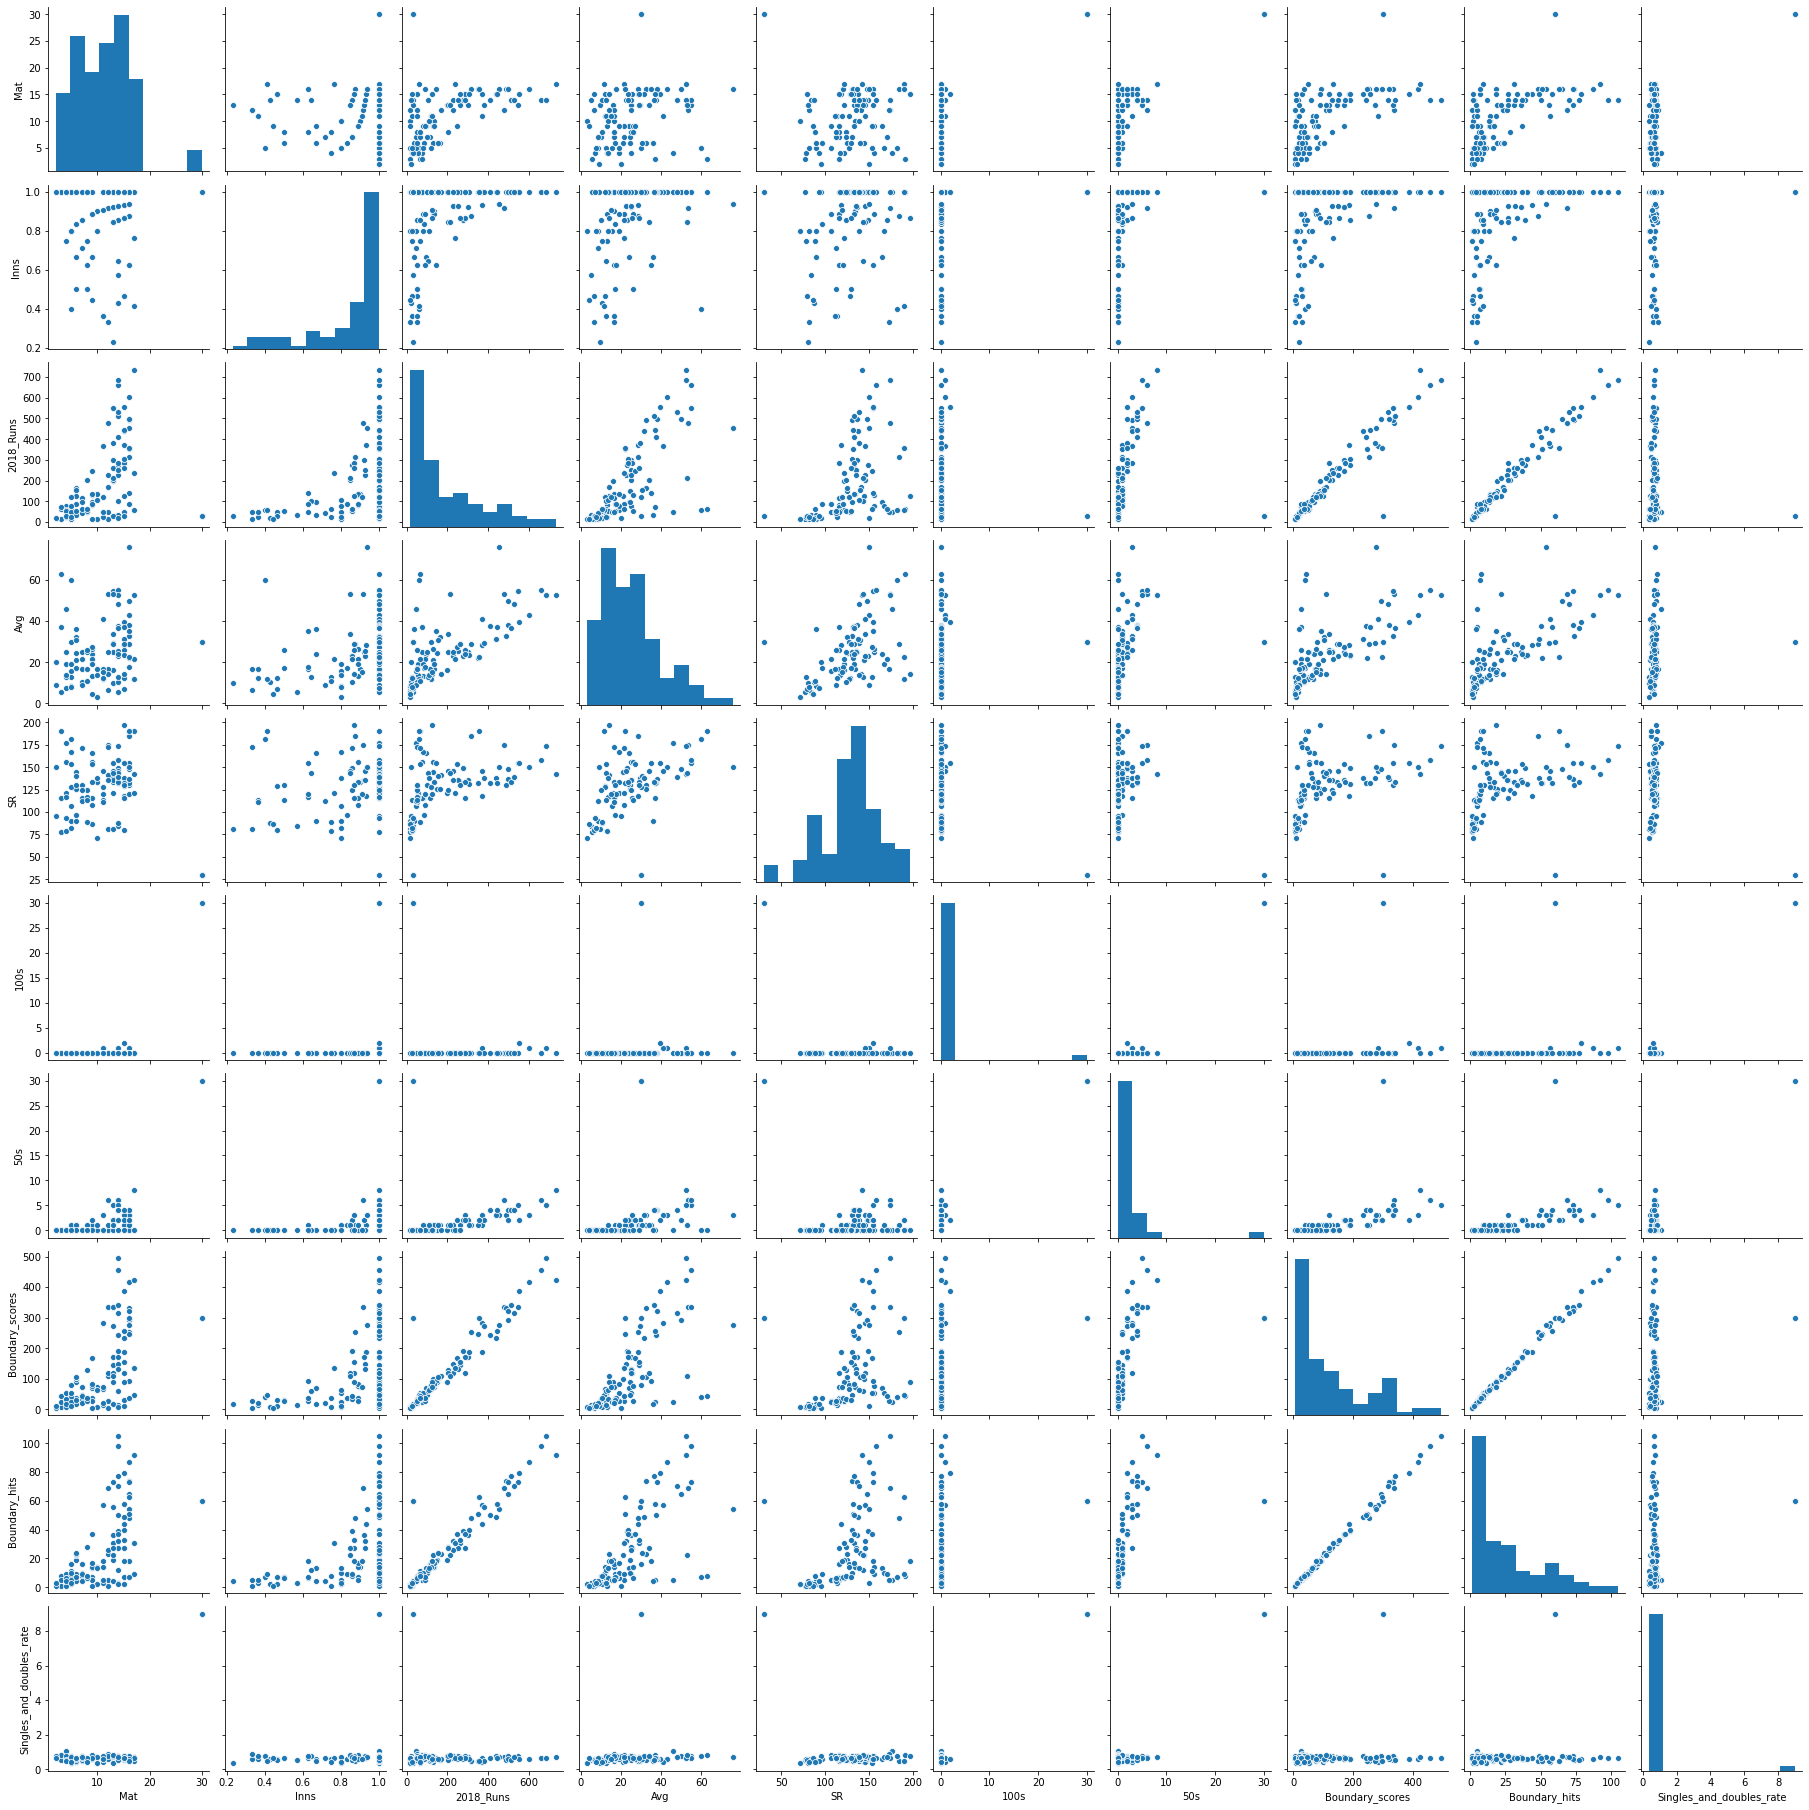

In [7]:
sns.pairplot(train_data[train_data.columns[:-1]])

## Plots of Inddividual Feature Distributions

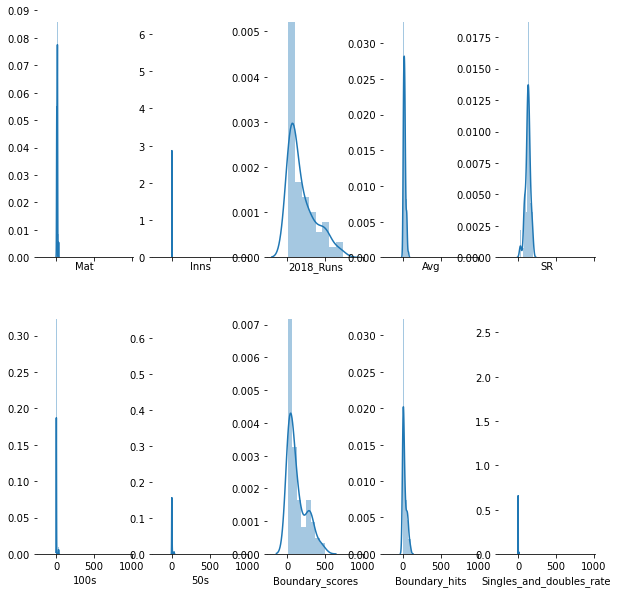

In [8]:
f, axes = plt.subplots(2,5,figsize = (10,10),sharex = True)
sns.despine(left = True)
for j,i in enumerate(train_data.columns[:-1]):
    sns.distplot(train_data[i],ax = axes[j//5,j%5])

In [9]:
last_c = train_data.columns[-1]
X,y = train_data.drop([last_c],axis = 1).values , train_data[last_c].values
X_train,X_test , y_train,y_test = train_test_split(X,y,test_size = 0.15,random_state = 42,shuffle = True)

## Validating different models to find the best one

Model : XGB , score : 0.9864384952498133
Model : RidgeRegression , score : 0.9857444560045
Model : DecisionTree , score : 0.9798585809599224
Model : RandomForest , score : 0.9897700649078282


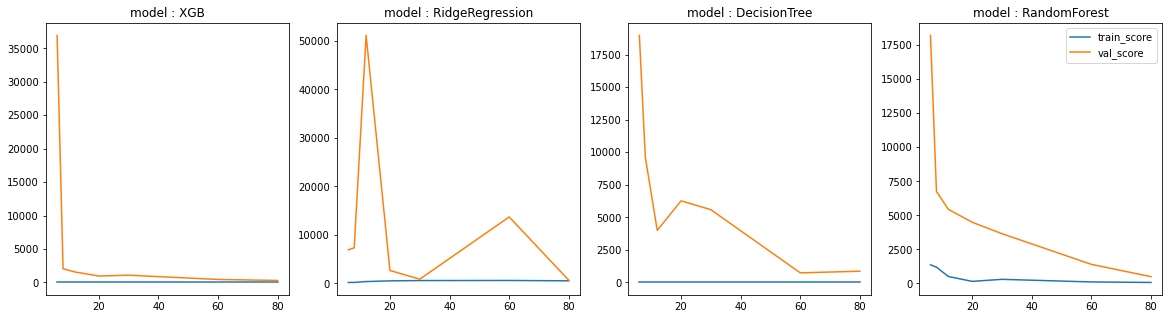

In [10]:
# train_data_copy = train_data
# train_data_copy.drop(['BF'],axis = 1).head()
# train_data_copy.tail()

model1 = xgb.XGBRegressor(learning_rate = 0.3,max_depth = 5)
# model2 = LogisticRegression()
model2 = Ridge()
model3 = DecisionTreeRegressor()
model4 = RandomForestRegressor()
models = [model1,model2,model3,model4]

#     model_pipe.fit(X_train,y_train)


f,axes = plt.subplots(1,4,figsize = (20,5))
for i,m in enumerate(['XGB','RidgeRegression','DecisionTree','RandomForest']):
    transformers = [('scale',StandardScaler()),
                ('m',models[i])]
    model_pipe = Pipeline(steps = transformers)
    train_sizes, train_scores , val_scores = learning_curve(model_pipe,X,y,train_sizes=[6,8,12,20,30,60,80],scoring = 'neg_mean_squared_error')
    train_scores =- train_scores.mean(axis = 1)
    val_scores =- val_scores.mean(axis = 1)
    axes[i].plot(train_sizes,train_scores,label = 'train_score')
    axes[i].plot(train_sizes,val_scores,label = 'val_score')
    axes[i].set_title('model : '+str(m))
    
    model_pipe.fit(X_train,y_train)
    
    print("Model : "+m + " , score : " + str(model_pipe.score(X_test,y_test)))
    
plt.legend()

plt.show()


# search = GridSearchCV(model_pipe,param_grid=param_grid,cv=5,n_jobs=-1,scoring='accuracy')
# search.fit(X_train,y_train)
# model.get_params().keys()



### From the above learning curves it is observed that XGBoost performs best in generalizing the training data

In [11]:
final_model = xgb.XGBRegressor()
param_grid = {
    'm__learning_rate':[0.01,0.03,0.1,0.3,0.9],
    'm__max_depth' : [4,5,6,7,9]
}
transformers = [('scale',StandardScaler()),
                ('m',final_model)]
model_pipe = Pipeline(steps = transformers)
search = GridSearchCV(model_pipe ,param_grid=param_grid,cv = 5)
search.fit(X_train,y_train)
print("Best Score = ",search.best_score_)
best_est = search.best_estimator_


Best Score =  0.9883296241582299


# Anaysing the best fit estimator test score and parameters

In [12]:
print(best_est.score(X_test,y_test))
best_est.get_params()

0.9877963103576156


{'memory': None,
 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('m',
   XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.1, max_delta_step=0, max_depth=4,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=1,
                objective='reg:squarederror', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
                validate_parameters=1, verbosity=None))],
 'verbose': False,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True),
 'm': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importa

# Predicting on actual test data

In [13]:
X_2019 = test_data.values
X_2019.shape


(100, 10)

In [32]:
predictions = best_est.predict(X_2019)
print(predictions)

[528.0485   521.117    487.84866  487.82462  463.70947  441.81784
 441.88278  415.57538  415.59308  404.1175   404.93408  402.83194
 402.3015   402.81067  402.711    402.50903  429.0997   397.39792
 397.2769   423.668    395.97415  371.89093  371.7595   371.94843
 371.8821   353.51984  351.101    353.4421   341.95575  332.71033
 334.652    318.70126  284.3046   280.49292  245.31258  220.53212
 220.26013  183.14911  183.14911  183.21765  182.42029  179.06812
 178.67384  179.26048  168.30092  161.05298  161.76501  114.93948
 108.777145  98.18562   98.40466   94.88952   94.78399   95.12341
  90.196686  85.82234   83.823906  84.02377   79.949875  79.989685
  69.818886  70.08162   70.05704   65.83915   65.78405   65.79692
  63.53739   61.22831   32.32708   29.588875  29.743845  29.577862
  20.595709  19.243048  19.225447  20.705286  19.04109   19.612886
  16.03484   15.260436  14.021963  30.089596  12.303446  11.859909
  12.064443  11.955316  11.923745  30.089596  12.010431  10.339646
   9.

In [39]:
name_of_player = test_data_['PLAYER'].values
answers = []
for name , score in zip(name_of_player,predictions):
    answers.append([name,score])

In [38]:
predictions.shape

(100,)

# Writing the final results to an excel file

In [45]:
results = pd.DataFrame(answers,columns = ['Player Name','Total Runs in IPL 2020'])
print(results)

          Player Name  Total Runs in IPL 2020
0        David Warner              528.048523
1            KL Rahul              521.117004
2     Quinton de Kock              487.848663
3      Shikhar Dhawan              487.824615
4       Andre Russell              463.709473
..                ...                     ...
95  Carlos Brathwaite                9.900070
96                 30               30.089596
97    Shakib Al Hasan               10.272360
98         Pawan Negi               10.000157
99                 30               30.089596

[100 rows x 2 columns]


In [54]:
results.to_excel('Aleem_Siddiqui_Submission.xlsx',index = False)